In [1]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    BatchNormalization,
    Activation,
    Layer,
    ReLU,
    LeakyReLU,
)
from tensorflow.keras import backend as K

2022-09-21 18:58:50.699423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-21 18:58:50.804489: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-21 18:58:51.202273: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-09-21 18:58:51.202317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
#from func import load_model, save_model

## Load dataset

In [3]:
filename = "processed-dataset-original/BKG_dataset.h5"

In [4]:
# make sure input data has correct input shape - background training data
with h5py.File(filename, "r") as file:
    X_train = np.array(file["X_train"])
    X_test = np.array(file["X_test"])
    X_val = np.array(file["X_val"])

## Define Dense NN architecture

In [5]:
input_shape = 57
latent_dimension = 3
num_nodes = [16, 8]

In [6]:
# encoder
inputArray = Input(shape=(input_shape))
x = Dense(num_nodes[0], use_bias=False)(inputArray)
x = Activation("relu")(x)
x = Dense(latent_dimension, use_bias=False)(x)
encoder = Activation("relu")(x)

# decoder
x = Dense(num_nodes[0], use_bias=False)(encoder)
x = Activation("relu")(x)
decoder = Dense(input_shape)(x)

# create autoencoder
autoencoder = Model(inputs=inputArray, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 57)]              0         
                                                                 
 dense (Dense)               (None, 16)                912       
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 48        
                                                                 
 activation_1 (Activation)   (None, 3)                 0         
                                                                 
 dense_2 (Dense)             (None, 16)                48        
                                                                 
 activation_2 (Activation)   (None, 16)                0     

2022-09-21 18:58:52.105719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 18:58:52.147805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 18:58:52.147960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 18:58:52.148544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
autoencoder.compile(optimizer=keras.optimizers.Adam(), loss="mse")

## Train model

In [8]:
EPOCHS = 10
BATCH_SIZE = 1024

In [9]:
history = autoencoder.fit(
    X_train,
    X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, X_val),
)

Epoch 1/10
 43/625 [=>............................] - ETA: 0s - loss: 86.6668   

2022-09-21 18:58:54.256481: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


625/625 [==============================] - 2s 2ms/step - loss: 25.4730 - val_loss: 3.4396
Epoch 2/10
625/625 [==============================] - 1s 1ms/step - loss: 2.4256 - val_loss: 2.1740
Epoch 3/10
625/625 [==============================] - 1s 1ms/step - loss: 2.0840 - val_loss: 2.0956
Epoch 4/10
625/625 [==============================] - 1s 1ms/step - loss: 2.0369 - val_loss: 2.0524
Epoch 5/10
625/625 [==============================] - 1s 1ms/step - loss: 2.0131 - val_loss: 2.0347
Epoch 6/10
625/625 [==============================] - 1s 1ms/step - loss: 1.9964 - val_loss: 2.0152
Epoch 7/10
625/625 [==============================] - 1s 1ms/step - loss: 1.9802 - val_loss: 2.0100
Epoch 8/10
625/625 [==============================] - 1s 1ms/step - loss: 1.9588 - val_loss: 1.9790
Epoch 9/10
625/625 [==============================] - 1s 1ms/step - loss: 1.9384 - val_loss: 1.9670
Epoch 10/10
625/625 [==============================] - 1s 1ms/step - loss: 1.9159 - val_loss: 1.9505


In [10]:
model_name = "model_name"
model_directory = ""
#save_model(model_directory + model_name, autoencoder)

## Prediction - background

In [11]:
bkg_prediction = autoencoder.predict(X_test)

6250/6250 [==============================] - 4s 555us/step


## Prediction - signals

In [12]:
# add correct signal labels
signal_labels = ["signal_1", "signal_2", "signal_3", "signal_4"]

In [13]:
# add correct path to signal files
signals_file = ["processed-dataset-original/Ato4l_lepFilter_13TeV_dataset.h5", "processed-dataset-original/hChToTauNu_13TeV_PU20_dataset.h5", "processed-dataset-original/hToTauTau_13TeV_PU20_dataset.h5", "processed-dataset-original/leptoquark_LOWMASS_lepFilter_13TeV_dataset.h5"]

In [14]:
# read signal data
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], "r") as file:
        test_data = np.array(file["Data"])
    signal_data.append(test_data)

In [15]:
signal_results = []

for i, label in enumerate(signal_labels):
    signal_prediction = autoencoder.predict(signal_data[i])
    signal_results.append(
        [label, signal_data[i], signal_prediction]
    )  # save [label, true, prediction] for signal

10642/10642 [==============================] - 6s 540us/step


## Save results

In [16]:
save_file = "save_file"

In [17]:
with h5py.File(save_file, "w") as file:
    file.create_dataset("BKG_input", data=X_test)
    file.create_dataset("BKG_predicted", data=bkg_prediction)
    for i, sig in enumerate(signal_results):
        file.create_dataset("%s_input" % sig[0], data=sig[1])
        file.create_dataset("%s_predicted" % sig[0], data=sig[2])

## Evaluate results

1. Plot loss distribution after prediction (check loss value for signals)
2. Plot ROC curves - how good is anomaly detection for chosen FPR threshold

# 1.

In [19]:
def mse_loss(true, prediction):
    loss = tf.reduce_mean(tf.math.square(true - prediction),axis=-1)
    return loss

In [20]:
# compute loss value (true, predicted)
total_loss = []
total_loss.append(mse_loss(X_test, bkg_prediction.astype(np.float32)).numpy())
for i, signal_X in enumerate(signal_data):
    total_loss.append(
        mse_loss(signal_X, signal_results[i][2].astype(np.float32)).numpy()
    )

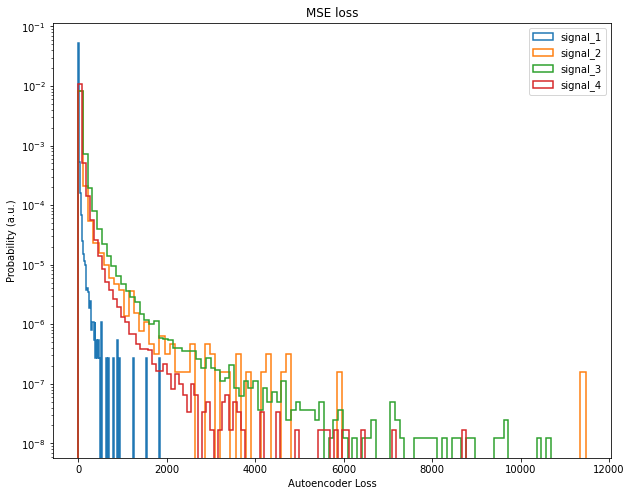

In [21]:
bin_size = 100

plt.figure(figsize=(10, 8))
for i, label in enumerate(signal_labels):
    plt.hist(
        total_loss[i],
        bins=bin_size,
        label=label,
        density=True,
        histtype="step",
        fill=False,
        linewidth=1.5,
    )
plt.yscale("log")
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title("MSE loss")
plt.legend(loc="best")
plt.show()

# 2.

In [22]:
from sklearn.metrics import roc_curve, auc

In [23]:
labels = np.concatenate([["Background"], np.array(signal_labels)])

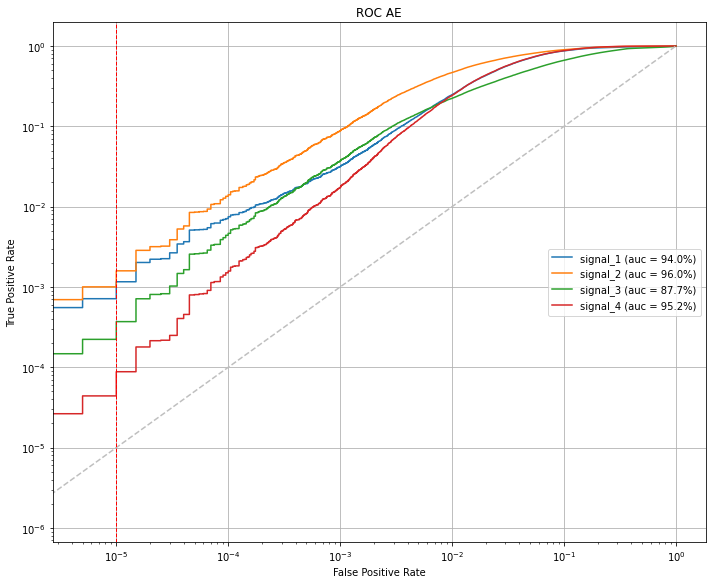

In [24]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10, 8))
for i, label in enumerate(labels):
    if i == 0:
        continue  # background events

    trueVal = np.concatenate(
        (np.ones(total_loss[i].shape[0]), target_background)
    )  # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)

    plt.plot(
        fpr_loss,
        tpr_loss,
        "-",
        label="%s (auc = %.1f%%)" % (label, auc_loss * 100.0),
        linewidth=1.5,
    )

    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc="center right")
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1), np.linspace(0, 1), "--", color="0.75")
plt.axvline(
    0.00001, color="red", linestyle="dashed", linewidth=1
)  # threshold value for measuring anomaly detection efficiency
plt.title("ROC AE")
plt.show()